# STAT 201 Group 43 - Group Project Proposal

## Title: Determining whether a mutant strain of the nematode C. elegans slows its rate of locomotion when in the presence of nutrients

In [ ]:
# Please run this cell before continuing, installing packages if necessary.
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
set.seed(2023)
options(repr.plot.width = 14, repr.plot.height = 8)

## Introduction

[placeholder]

## Preliminary results

[placeholder]

In [23]:
worm_data_raw <- read_csv('N2_CB1112_baseline_output_12_11_2022.csv', show_col_types = FALSE)

head(worm_data_raw)
nrow(worm_data_raw)

time_bin,worm,time,speed,x,y,angularspeed,pathlength,kink,bias,curve,dir,crab,length,midline,width,morphwidth,area,Strain
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
5,27,4.707,0.2312,23.73,29.97,10.880,0.07470,57.80,1,42.10,0,0.02003,0.7560,0.9690,0.2386,0.0867,0.0871,N2_Food
5,156,4.484,0.2195,36.94,25.75,7.300,0.13040,34.50,1,31.17,0,0.02087,0.9320,1.0360,0.1998,0.1648,0.1556,N2_Food
5,185,4.715,0.2563,25.62,24.98,34.660,0.08360,38.50,1,30.64,0,0.02118,0.7200,0.9310,0.2660,0.1404,0.1324,N2_Food
5,192,4.600,0.1354,28.47,19.23,5.484,0.06230,28.60,1,26.06,0,0.00981,0.5806,0.8200,0.1979,0.1378,0.1079,N2_Food
5,198,4.715,0.1797,24.28,30.77,3.680,0.05940,48.56,1,35.38,0,0.01484,0.7950,0.9263,0.1696,0.1467,0.1315,N2_Food
5,208,4.824,0.2135,27.83,25.23,5.035,0.05133,51.94,1,34.78,0,0.00853,0.8657,0.9717,0.2160,0.1774,0.1526,N2_Food


[1] 252756

In [40]:
#Select worm, speed, Strain column
#Filter observations with Strain "CB1112_Food" and "CB1112_NoFood"
worm_data_cleaned <- worm_data_raw |>
select(worm, speed, Strain) |>
filter(Strain %in% c("CB1112_Food", "CB1112_NoFood"))

#Change "CB1112_Food" to "Food", "CB1112_NoFood" to "NoFood", rename the column "Strain" as "food_status"
worm_data_cleaned$Strain[worm_data_cleaned$Strain=="CB1112_Food"] <- "Food"
worm_data_cleaned$Strain[worm_data_cleaned$Strain=="CB1112_NoFood"] <- "NoFood"
colnames(worm_data_cleaned)[3]  <- "food_status"  

head(worm_data_cleaned)
nrow(worm_data_cleaned)

worm,speed,food_status
<dbl>,<dbl>,<chr>
16,0.2883,Food
114,0.2588,Food
177,0.3000,Food
194,0.2423,Food
198,0.2161,Food
238,0.1821,Food


[1] 63190

In [41]:
# mean, standard deviation, number of observations
summary <- worm_data_cleaned |>
group_by(food_status) |>
summarize(mean = mean(speed), 
          sd = sd(speed),
          n=n())
summary

food_status,mean,sd,n
<chr>,<dbl>,<dbl>,<int>
Food,0.1762056,0.07131272,34792
NoFood,0.1973733,0.08025806,28398


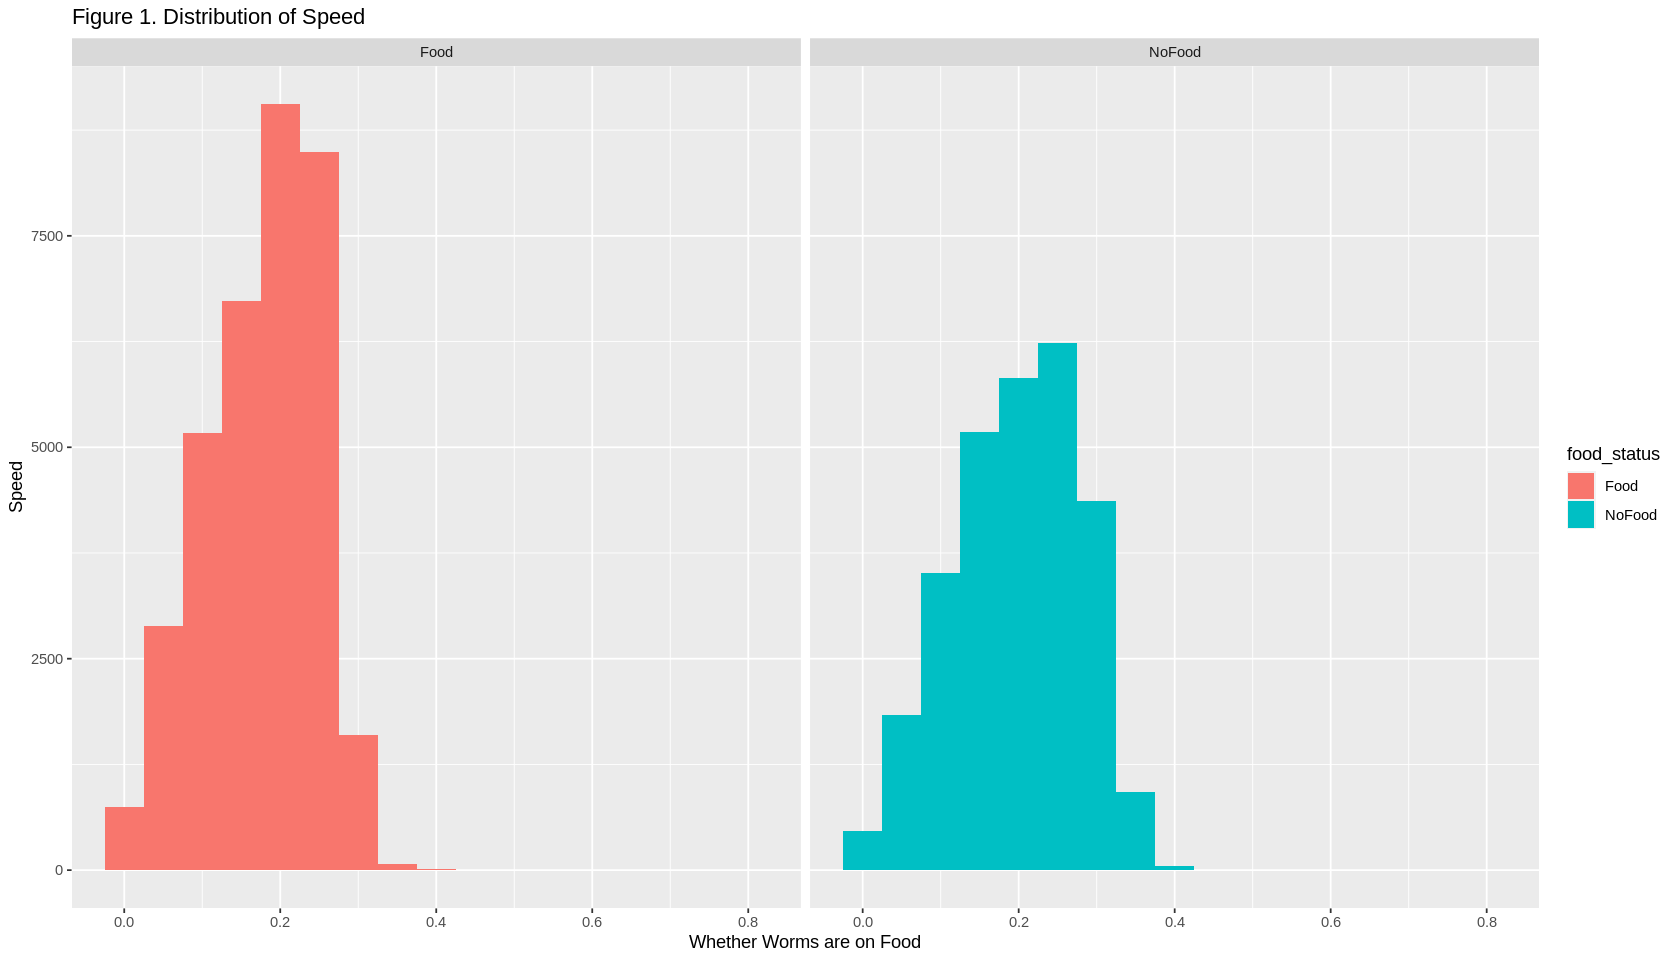

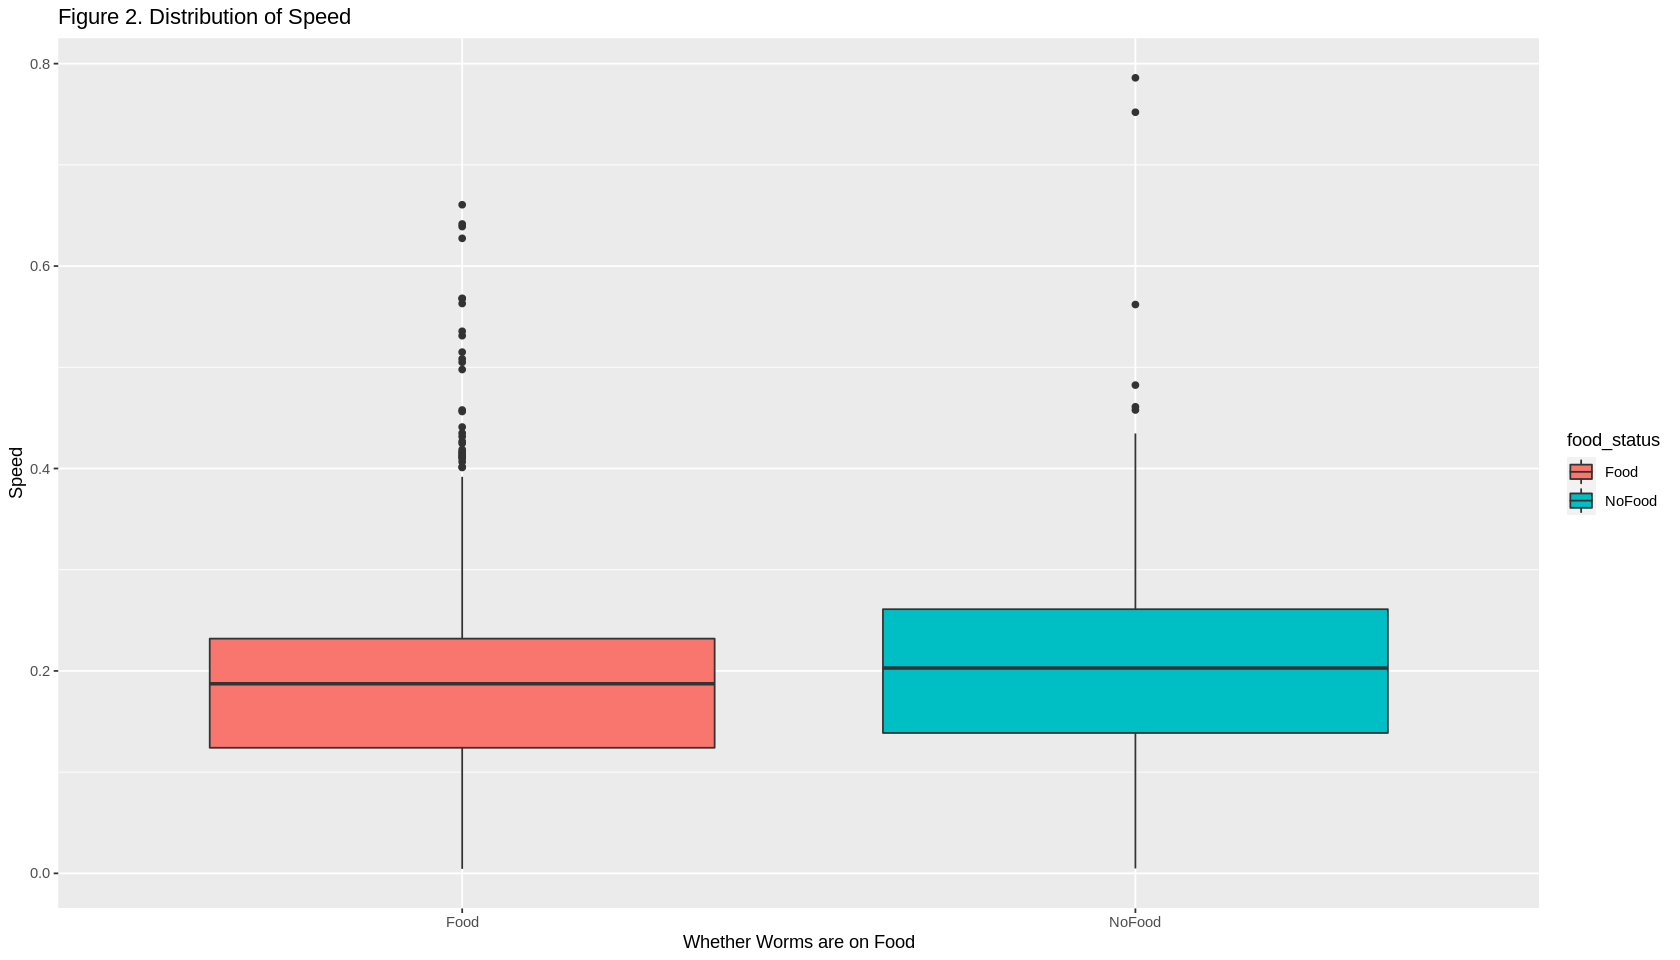

In [42]:
#Plots
hist <- worm_data_cleaned |>
ggplot(aes(x=speed, fill=food_status)) +
geom_histogram(binwidth=0.05) +
facet_grid(~food_status) +
labs(x="Whether Worms are on Food",
     y="Speed",
     title = "Figure 1. Distribution of Speed")

hist

boxplot <- worm_data_cleaned |>
ggplot() +
geom_boxplot(aes(food_status, speed, fill = food_status)) +
labs(x="Whether Worms are on Food",
     y="Speed",
     title = "Figure 2. Distribution of Speed")

boxplot

## Methods: Plan

[placeholder]

## References

[placeholder]